In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
import warnings
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [52]:
files = ["cleaned.csv"]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
df = pd.concat(dfs, axis=0)

In [53]:
df['gender'].value_counts()

gender
male      21762
female    20356
Name: count, dtype: int64

In [54]:
df['age'].value_counts()

age
fifties     21691
twenties    20427
Name: count, dtype: int64

In [55]:
## check for duplicates in the dataset
duplicates = df.duplicated()
duplicates_count = duplicates.sum()
print(duplicates_count)

0


0    11044
3    10973
2    10718
1     9383
Name: count, dtype: int64
(42118, 107)


/var/folders/2q/6vjsrj112rb774fzn79lb71h0000gn/T/ipykernel_78233/981349969.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=classes, data=df, palette='Set2')


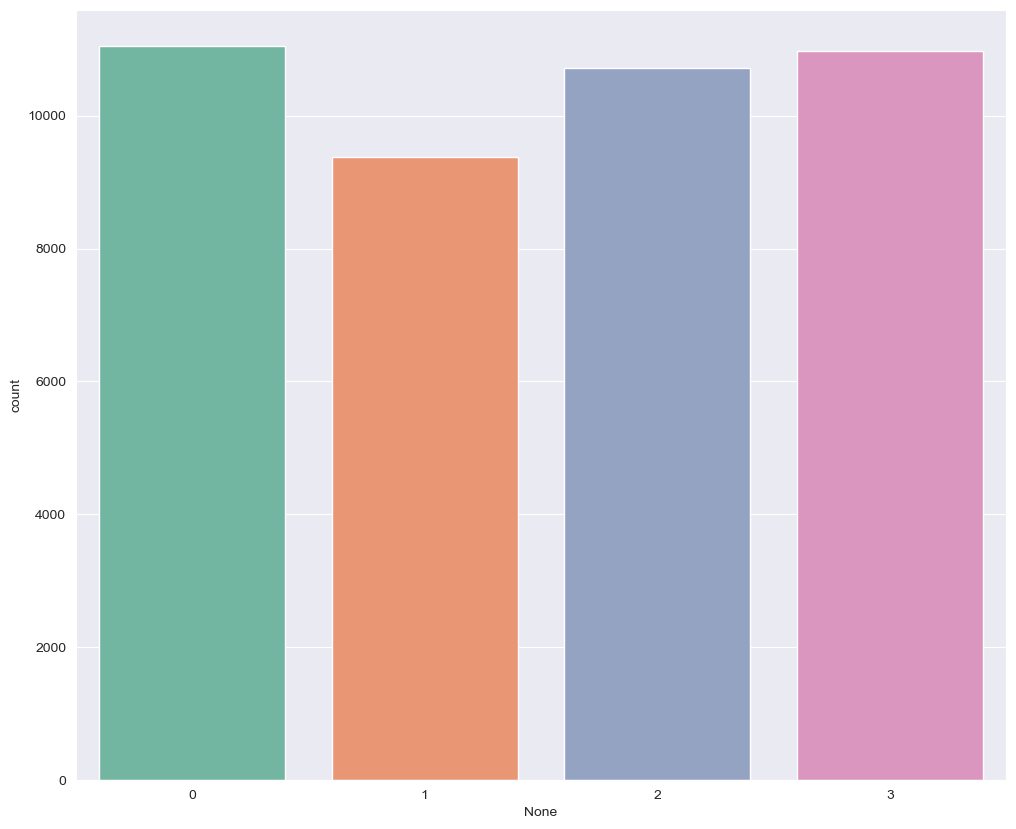

In [56]:
plt.figure(figsize=(12, 10))
df['gender'] = df['gender'].map({'male': 0, 'female': 1, 0:0, 1:1})
df['age'] = df['age'].map({'twenties': 0, 'fifties': 1, 0:0, 1:1})
classes = df['gender'].copy() + 2 * df['age'].copy()
print(classes.value_counts())
sns.countplot(x=classes, data=df, palette='Set2')
print(df.shape)

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
def grid_search_sequential(model_gender, model_age,params_gender, params_age, X_reduced,df, proba = False, verbose_level = 2, mode = 'both'):
    X_reduced = np.array(X_reduced)
    y = np.array(df['gender'] + 2 * df['age'])
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    y_train_gender = y_train % 2
    y_train_age = y_train // 2
    y_test_gender = y_test % 2
    y_test_age = y_test // 2
    if params_gender is not None:
        gender_grid = RandomizedSearchCV(model_gender, param_distributions=params_gender, cv=5, n_jobs=-1, verbose=verbose_level)
        gender_grid.fit(X_train, y_train_gender)
        gender_classifier = gender_grid.best_estimator_
        gender_best_params = gender_grid.best_params_
        gender_best_score = gender_grid.best_score_
    else:
        gender_classifier = model_gender
        model_gender.fit(X_train,y_train_gender)
        gender_best_score = None
        gender_best_params = None
    if(mode == 'gender'):
        gender_pred_test = gender_classifier.predict(X_test).reshape(-1, 1)
        gender_acc = accuracy_score(y_test_gender, gender_pred_test)
        print("Test set accuracy", gender_acc)
        print("Grid Accuracy", gender_best_score)
        return gender_classifier, gender_best_params
    ## cross prediction
    cv_gender_pred = cross_val_predict(
        gender_classifier,
        X_train,
        y_train_gender,
        cv=5,
        method='predict_proba' if proba else 'predict'
    )

    # Format prediction as new feature
    if proba:
        predicted_gender = cv_gender_pred[:, 1].reshape(-1, 1)
    else:
        predicted_gender = cv_gender_pred.reshape(-1, 1)
    ## concatenate gender
    X_train = np.concatenate([X_train, predicted_gender], axis=1)
    if params_age is not None:
        age_grid = RandomizedSearchCV(model_age, param_distributions=params_age, cv=5, n_jobs=-1, verbose=verbose_level)
        age_grid.fit(X_train, y_train_age)
        age_classifier = age_grid.best_estimator_
        age_best_params = age_grid.best_params_
    else:
        age_classifier = model_age
        model_age.fit(X_train,y_train_age)
        age_best_params = None

    ### accuracy
    gender_pred_test = gender_classifier.predict(X_test).reshape(-1, 1)
    gender_acc = accuracy_score(y_test_gender, gender_pred_test)
    print("Gender Accuracy:", gender_acc)
    if(proba):
        gender_proba_test = gender_classifier.predict_proba(X_test)[:,1].reshape(-1, 1)
        X_test = np.concatenate([X_test, gender_proba_test], axis=1)
    else:
        X_test = np.concatenate([X_test, gender_pred_test], axis=1)
    age_pred_test = age_classifier.predict(X_test).reshape(-1, 1)
    age_acc = accuracy_score(y_test_age, age_pred_test)
    print("Age Accuracy:", age_acc)

    gender_age = gender_pred_test + 2 * age_pred_test
    total_acc = accuracy_score(gender_age, y_test)

    print("Total Accuracy:", total_acc)

    return gender_classifier, age_classifier, gender_best_params, age_best_params, total_acc

In [58]:
def grid_search_both(model_both, params_both, X_reduced,verbose_level = 2):
    X_reduced = np.array(X_reduced)
    y = np.array(df['gender'] + 2 * df['age'])
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    grid = RandomizedSearchCV(model_both, param_distributions=params_both, cv=5, n_jobs=-1, verbose=verbose_level)
    grid.fit(X_train, y_train)
    classifier = grid.best_estimator_
    classifier_best_params = grid.best_params_
    classifier_best_score = grid.best_score_
    print("Best parameters:", classifier_best_params)
    print("Best score:", classifier_best_score)
    print("Test set accuracy:", classifier.score(X_test, y_test))
    return classifier, classifier_best_params, classifier_best_score

In [59]:
def predict_gender_age(model_gender, model_age, X, proba):
    gender = model_gender.predict(X).reshape(-1, 1)
    if(proba):
        gender_proba = model_gender.predict_proba(X)[:,1].reshape(-1, 1)
        X = np.concatenate([X, gender_proba], axis=1)
    else:
        X = np.concatenate([X, gender], axis = 1)
    age = model_age.predict(X).reshape(-1, 1)
    return (gender + 2 * age).flatten()

Sequential Accuracy with the result gender (not proba)
Gender 0.88, age = 0.81, both 0.74

Sequential Accuracy with the result gender proba both 73, age worse than above 0.73


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
def smart_normalize(df, skew_threshold=0.5):

    numeric_cols = df.select_dtypes(include=['number']).columns
    df_normalized = df.copy()
    transformations = {}

    # Step 1: Skewness correction
    for col in numeric_cols:
        col_skew = skew(df[col].dropna())
        if abs(col_skew) > skew_threshold:
            # Apply Yeo-Johnson power transform (handles positive/negative values)
            pt = PowerTransformer(method='yeo-johnson')
            df_normalized[col] = pt.fit_transform(df[[col]]).flatten()
            transformations[col] = {
                'step1': 'power_transform',
                'skewness': col_skew,
                'transformer': pt
            }
        else:
            transformations[col] = {
                'step1': 'none',
                'skewness': col_skew
            }

    # Step 2: Standard scaling (applied to all numeric columns)
    scaler = StandardScaler()
    df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])
    transformations['_standard_scaler'] = scaler

    return df_normalized, transformations
def normalize_test(X_test, transformations):
    X_test_normalized = X_test.copy()
    for col, info in transformations.items():
        if col == '_standard_scaler':
            continue
        if info['step1'] == 'power_transform':
            pt = info['transformer']
            X_test_normalized[col] = pt.transform(X_test[[col]]).flatten()

    # Apply standard scaling using the saved scaler
    scaler = transformations['_standard_scaler']
    numeric_cols = X_test.select_dtypes(include=['number']).columns
    X_test_normalized[numeric_cols] = scaler.transform(X_test_normalized[numeric_cols])
    return X_test_normalized


After CHANGING the grid search for more features =>

In [61]:
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from Linear_Model_Tree import LinearModelTree
from sklearn.naive_bayes import GaussianNB
import pickle
X = df.drop('gender', axis=1).drop('age',axis=1)
y = np.array(df['gender'] + 2 * df['age'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, transformations = smart_normalize(X_train)
X_test = normalize_test(X_test, transformations)
y_train_gender = y_train % 2
y_train_age = y_train // 2
y_test_gender = y_test % 2
y_test_age = y_test // 2

In [62]:
def baseline_with_selection(X_train, y_train, X_test, y_test):
    total_features = X_train.shape[1]
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(total_features)]

    accuracy_results = []
    best_k = -1
    max_acc = -1
    it_acc = -1

    for k in range(total_features, 9, -5):  # Reverse loop from total_features to 60, step -5
        print(f"\n===== Evaluating with top {k} features =====")
        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X_train, y_train)

        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)

        clf = KNeighborsClassifier()
        clf.fit(X_train_selected, y_train)

        y_pred = clf.predict(X_test_selected)
        acc = accuracy_score(y_test, y_pred)
        accuracy_results.append((k, acc))

        if acc > max_acc:
            max_acc = acc
            it_acc = acc
            best_k = k
        elif max_acc - acc <= 0.001:
            best_k = k
            it_acc = acc

    # Plotting accuracy vs k
    ks, accs = zip(*accuracy_results)
    plt.figure(figsize=(8, 6))
    plt.plot(ks, accs, marker='o')
    plt.title("Accuracy vs Number of Selected Features")
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.gca().invert_xaxis()  # reverse x-axis to match loop
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nBest k: {best_k} with accuracy: {it_acc:.4f}")
    return best_k


===== Evaluating with top 105 features =====

===== Evaluating with top 100 features =====

===== Evaluating with top 95 features =====

===== Evaluating with top 90 features =====

===== Evaluating with top 85 features =====

===== Evaluating with top 80 features =====

===== Evaluating with top 75 features =====

===== Evaluating with top 70 features =====

===== Evaluating with top 65 features =====

===== Evaluating with top 60 features =====

===== Evaluating with top 55 features =====

===== Evaluating with top 50 features =====

===== Evaluating with top 45 features =====

===== Evaluating with top 40 features =====

===== Evaluating with top 35 features =====

===== Evaluating with top 30 features =====

===== Evaluating with top 25 features =====

===== Evaluating with top 20 features =====

===== Evaluating with top 15 features =====

===== Evaluating with top 10 features =====


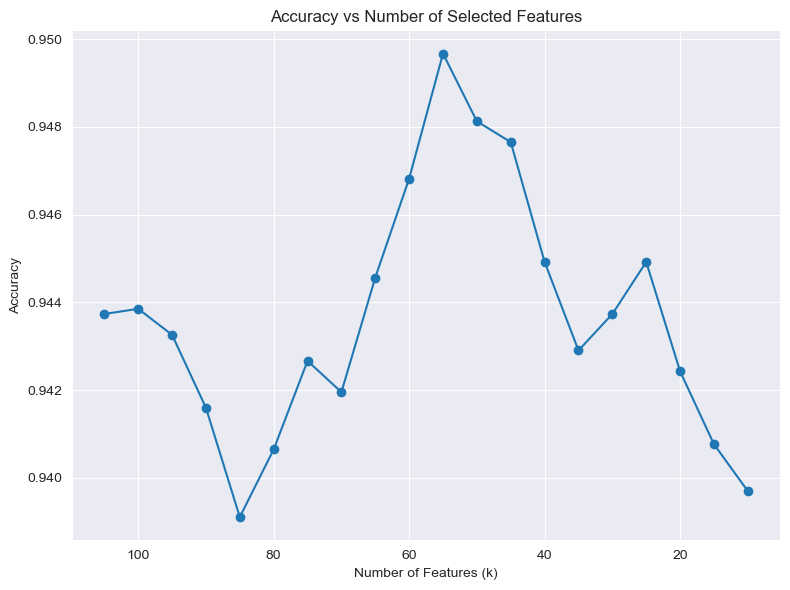


Best k: 55 with accuracy: 0.9497


In [68]:
gen_k = baseline_with_selection(X_train, y_train_gender, X_test, y_test_gender)

selector = SelectKBest(score_func=f_classif, k=gen_k)
selector.fit(X_train, y_train_gender)

selected_indices = selector.get_support(indices=True)
selected_columns = X_train.columns[selected_indices]

X_train_gender_final = pd.DataFrame(selector.transform(X_train), columns=selected_columns, index=X_train.index)
X_test_gender_final = pd.DataFrame(selector.transform(X_test), columns=selected_columns, index=X_test.index)


===== Evaluating with top 105 features =====

===== Evaluating with top 100 features =====

===== Evaluating with top 95 features =====

===== Evaluating with top 90 features =====

===== Evaluating with top 85 features =====

===== Evaluating with top 80 features =====

===== Evaluating with top 75 features =====

===== Evaluating with top 70 features =====

===== Evaluating with top 65 features =====

===== Evaluating with top 60 features =====

===== Evaluating with top 55 features =====

===== Evaluating with top 50 features =====

===== Evaluating with top 45 features =====

===== Evaluating with top 40 features =====

===== Evaluating with top 35 features =====

===== Evaluating with top 30 features =====

===== Evaluating with top 25 features =====

===== Evaluating with top 20 features =====

===== Evaluating with top 15 features =====

===== Evaluating with top 10 features =====


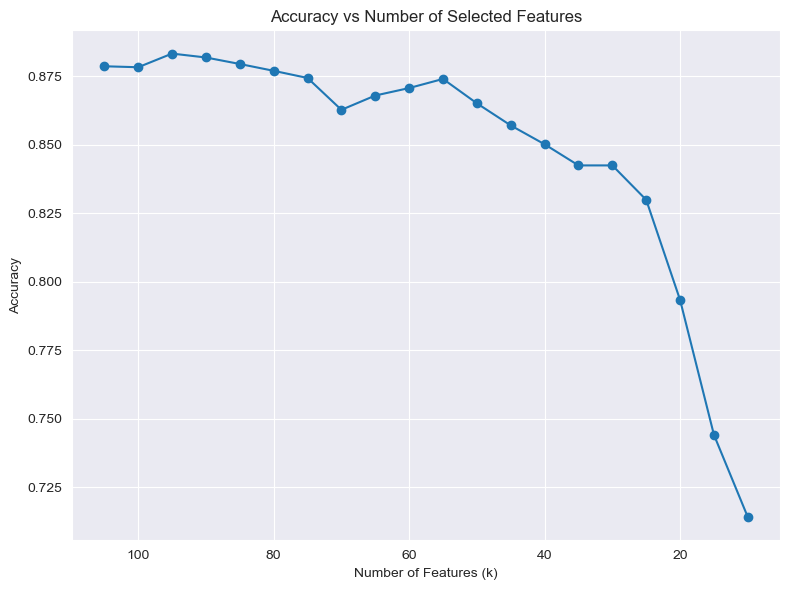


Best k: 95 with accuracy: 0.8833


In [69]:
age_k = baseline_with_selection(X_train, y_train_age, X_test, y_test_age)

selector_age = SelectKBest(score_func=f_classif, k=age_k)
selector_age.fit(X_train, y_train_age)

selected_indices = selector_age.get_support(indices=True)
selected_columns = X_train.columns[selected_indices]

X_train_age_final = pd.DataFrame(selector_age.transform(X_train), columns=selected_columns, index=X_train.index)
X_test_age_final = pd.DataFrame(selector_age.transform(X_test), columns=selected_columns, index=X_test.index)


===== Evaluating with top 105 features =====

===== Evaluating with top 100 features =====

===== Evaluating with top 95 features =====

===== Evaluating with top 90 features =====

===== Evaluating with top 85 features =====

===== Evaluating with top 80 features =====

===== Evaluating with top 75 features =====

===== Evaluating with top 70 features =====

===== Evaluating with top 65 features =====

===== Evaluating with top 60 features =====

===== Evaluating with top 55 features =====

===== Evaluating with top 50 features =====

===== Evaluating with top 45 features =====

===== Evaluating with top 40 features =====

===== Evaluating with top 35 features =====

===== Evaluating with top 30 features =====

===== Evaluating with top 25 features =====

===== Evaluating with top 20 features =====

===== Evaluating with top 15 features =====

===== Evaluating with top 10 features =====


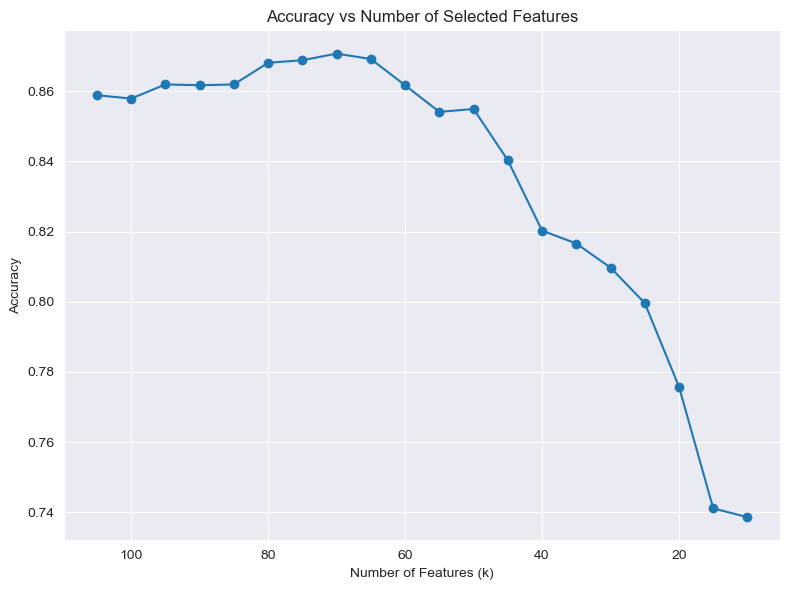


Best k: 70 with accuracy: 0.8707


In [70]:
both_k = baseline_with_selection(X_train, y_train, X_test, y_test)

selector_both = SelectKBest(score_func=f_classif, k=both_k)
selector_both.fit(X_train, y_train)

selected_indices = selector_both.get_support(indices=True)
selected_columns = X_train.columns[selected_indices]

X_train_both_final = pd.DataFrame(selector_both.transform(X_train), columns=selected_columns, index=X_train.index)
X_test_both_final = pd.DataFrame(selector_both.transform(X_test), columns=selected_columns, index=X_test.index)

In [78]:
def train_stack(X_train, y_train, X_test, y_test, base_models, base_parameters, meta_model,svc_model = None, n_folds=5, search = True):
    # Create base models
    base_models_list = []
    for model_name, model in base_models.items():
        print(f"Training base model: {model_name}")
        # Perform RandomizedSearchCV for each base model
        if (search):
            grid = RandomizedSearchCV(model, param_distributions=base_parameters[model_name], cv=n_folds, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters for {model_name}: {grid.best_params_}")
            print(f"Best score for {model_name}: {grid.best_score_}")
        else:
            best_model = model
            model.fit(X_train, y_train)
            print(f"Training score for {model_name}: {model.score(X_train, y_train)}")
        base_models_list.append((model_name, best_model))
    # Create meta Model
    ## append SVC
    if svc_model is not None:
        base_models_list.append(('svc', svc_model))
    print("Training meta model")
    stacking_clf = StackingClassifier(
    estimators=base_models_list,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    stack_method='auto',
    n_jobs=-1
)
    stacking_clf.fit(X_train, y_train)
    print("Meta model training complete")
    print("Training Accuracy score:", stacking_clf.score(X_train, y_train))
    print("Meta model test score:", stacking_clf.score(X_test, y_test))
    return stacking_clf, base_models_list

In [ ]:
## SAMER TRIED RBF C = 10

In [15]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 10) #0.7 => 7 degree rbf 10000
# poly 8, 10000 0.8 test 1 training
# poly 4, 10000 0.87 test 1 training
# poly 4, 1000 0.87 test 1 training
# poly 4, 10 0.87 test 0.9975 training
# poly 3, 10 0.87 test 0.9975 training
# poly 2, 10 0.79 test 0.93 training
# poly 2, 1 0.78 test 0.85 training
# poly 4 0.01 30%
# linear C = 1 0.71, 0.68

#68 66
svc.fit(X_train, y_train)
print("Accuracy on training: ", svc.score(X_train, y_train))
print("Accuracy on test: ", svc.score(X_test, y_test))


Accuracy on training:  0.6868285154626936
Accuracy on test:  0.6665479582146249


In [16]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Kernel approximation
nystroem = Nystroem(kernel='poly', degree=2, coef0=1, gamma=1, n_components=1000)
# 1000 79 76
# Classifier with regularization parameter C
clf = LinearSVC(C=100000, max_iter=10000)

# Full pipeline
pipeline = make_pipeline(StandardScaler(), nystroem, clf)

pipeline.fit(X_train, y_train)
print("Train accuracy:", pipeline.score(X_train, y_train))
print("Test accuracy:", pipeline.score(X_test, y_test))

Train accuracy: 0.7902000356146495
Test accuracy: 0.7548670465337132


In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

base_svm = pipeline
bagged_svm = BaggingClassifier(

    estimator=base_svm,
    n_estimators=50,
    max_samples=0.8,
    max_features=1,
    bootstrap=True,
    random_state=42
)

bagged_svm.fit(X_train, y_train)
print("Accuracy on training: ", bagged_svm.score(X_train, y_train))
print("Accuracy on test: ", bagged_svm.score(X_test, y_test))

Accuracy on training:  0.35403929482994007
Accuracy on test:  0.35208926875593544


In [99]:
base_models = {
    'rf': RandomForestClassifier(max_depth = 5, max_features = 'log2', n_estimators = 1000),
    'et': ExtraTreesClassifier(max_depth = 5, max_features = 'log2', n_estimators = 2000 ),
    'knn': KNeighborsClassifier(),
    'svc': SVC(probability=True, C = 10, kernel = 'rbf'),
}
params_dict = {
    'et': {
        'n_estimators': [500,1000,1500,2000,2500],
        'max_depth': [None, 5, 10, 20,30,50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2',15,20,25,30,35,40],
    },
    'rf': {
    'n_estimators': [10, 20, 50, 100,300,500,700,1000, 1500],
    'max_depth': [None, 5, 10, 20,30,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',15,20,25,30,35,40],
},
    'knn': {
        'n_neighbors': [1, 3, 5, 7, 9, 11,13,15,17,19,21],
        'weights': ['uniform', 'distance'],
    }
}
meta_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000)    # was 0.01

In [ ]:
stacking_clf_gender, base_models_list_gender = train_stack(X_train_gender_final ,y_train_gender, X_test_gender_final, y_test_gender, base_models, params_dict, meta_model, search = False)

Training base model: rf


In [26]:
stacking_clf_both, base_models_list_both = train_stack(X_train,y_train, X_test, y_test, base_models, params_dict, meta_model)

Training base model: rf
Best parameters for rf: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best score for rf: 0.8247462273865513
Training base model: et


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for et: {'n_estimators': 2500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 20, 'max_depth': 50}
Best score for et: 0.8670089590278515
Training base model: knn
Best parameters for knn: {'weights': 'uniform', 'n_neighbors': 3}
Best score for knn: 0.8574226014615862
Training meta model
Meta model training complete
Training score: 1.0
Meta model test score: 0.9132241215574549


In [28]:
print("Training Accuracy:", stacking_clf_both.score(X_train, y_train))
print("Test Accuracy:", stacking_clf_both.score(X_test, y_test))
### that was with SVM as Meta classifier
meta_model = LogisticRegression(penalty='l2', C=1, solver='lbfgs')

Training Accuracy: 1.0
Test Accuracy: 0.9132241215574549


In [29]:
stacking_clf, base_models_list = train_stack(X_train,y_train_gender, X_test, y_test_gender, base_models, params_dict, meta_model)

Training base model: rf
Best parameters for rf: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 35, 'max_depth': 50}
Best score for rf: 0.9578857376098009
Training base model: et


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for et: {'n_estimators': 2500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 40, 'max_depth': 50}
Best score for et: 0.9619220548764517
Training base model: knn
Best parameters for knn: {'weights': 'uniform', 'n_neighbors': 5}
Best score for knn: 0.9440553344387924
Training meta model
Meta model training complete
Training score: 1.0
Meta model test score: 0.9718660968660968


In [30]:
gender_pred = stacking_clf.predict(X_train).reshape(-1, 1)
X_train_hard_gender = np.concatenate([X_train, gender_pred], axis=1)
gender_pred_test = stacking_clf.predict(X_test).reshape(-1, 1)
X_test_hard_gender = np.concatenate([X_test, gender_pred_test], axis=1)
stacking_clf_cascaded_hard, base_models_cascaded_hard = train_stack(X_train_hard_gender, y_train, X_test_hard_gender, y_test, base_models, params_dict, meta_model)

Training base model: rf
Best parameters for rf: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 15, 'max_depth': None}
Best score for rf: 0.8714310153357884
Training base model: et


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for et: {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 30, 'max_depth': 20}
Best score for et: 0.8953521918528577
Training base model: knn
Best parameters for knn: {'weights': 'uniform', 'n_neighbors': 1}
Best score for knn: 0.8606277719336471
Training meta model
Meta model training complete
Training score: 1.0
Meta model test score: 0.907051282051282


LogisticRegression(C=1)


In [31]:
gender_pred_proba_train = stacking_clf.predict_proba(X_train)[:, 1].reshape(-1,1)
X_train_soft_gender = np.concatenate([X_train, gender_pred_proba_train], axis=1)
gender_pred_proba_test = stacking_clf.predict_proba(X_test)[:, 1].reshape(-1,1)
X_test_soft_gender = np.concatenate([X_test, gender_pred_proba_test], axis=1)
stacking_clf_cascaded_soft, base_models_cascaded_soft = train_stack(X_train_soft_gender, y_train, X_test_soft_gender, y_test, base_models, params_dict, meta_model)

Training base model: rf
Best parameters for rf: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': None}
Best score for rf: 0.8797707297901474
Training base model: et


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for et: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 25, 'max_depth': None}
Best score for et: 0.9017034631065055
Training base model: knn
Best parameters for knn: {'weights': 'uniform', 'n_neighbors': 3}
Best score for knn: 0.8626757781366916
Training meta model
Meta model training complete
Training score: 1.0
Meta model test score: 0.9094254510921178


In [33]:

y_pred_test = stacking_clf_both.predict(X_test)


In [36]:
print(y_test)
print(y_pred_test)

[3 3 1 ... 0 3 3]
[1 3 1 ... 2 3 3]


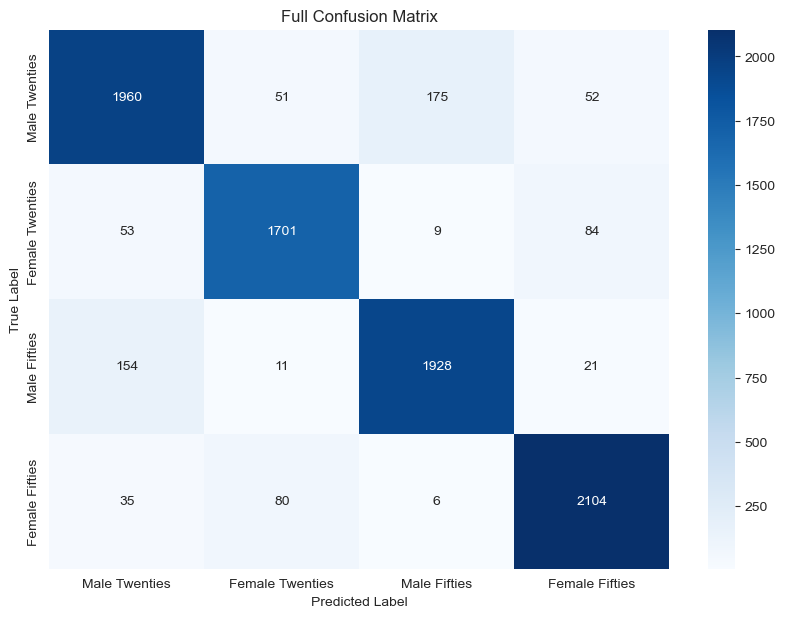

In [37]:
from collections import defaultdict, Counter
def classification_counts(y_pred_test, y_test):
    confusion = Counter()
    for true, pred in zip(y_test, y_pred_test):
        confusion[(true, pred)] += 1
    return confusion

confusion_counts = classification_counts(y_pred_test, y_test)
all_labels = sorted(set(y_test) | set(y_pred_test))

df_2 = pd.DataFrame(0, index=all_labels, columns=all_labels)

for (true_label, pred_label), count in confusion_counts.items():
    df_2.loc[true_label, pred_label] = count

label_map = {
    0: 'Male Twenties',
    1: 'Female Twenties',
    2: 'Male Fifties',
    3: 'Female Fifties'
}

df_2.index = df_2.index.map(label_map)
df_2.columns = df_2.columns.map(label_map)

plt.figure(figsize=(10, 7))
sns.heatmap(df_2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Full Confusion Matrix')
plt.show()

    0

90.7 Accuracy Age , 86.4 total accuracy => svc in base + meta = Logistic

Same for meta = RandomForestClassifier

In [129]:
KNN = KNeighborsClassifier()
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11,13,15,17,19,21],
    'weights': ['uniform', 'distance'],
}
model_both_knn, params_model_both_knn, acc_both_knn = grid_search_both(KNN, params, X_reduced, verbose_level = 2)
ET = ExtraTreesClassifier()
params = {
    'n_estimators': [10, 20, 50, 100,300,500,700,1000, 1500],
    'max_depth': [None, 5, 10, 20,30,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',15,20,25,30,35,40],
}
model_both_et, params_model_both_et, acc_both_et = grid_search_both(ET, params, X_reduced, verbose_level = 2)
RF = RandomForestClassifier()
params = {
    'n_estimators': [10, 20, 50, 100,300,500,700,1000, 1500],
    'max_depth': [None, 5, 10, 20,30,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',15,20,25,30,35,40],
}
model_both_rf, params_model_both_rf, acc_both_rf = grid_search_both(RF, params, X_reduced, verbose_level = 2)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'weights': 'uniform', 'n_neighbors': 1}
Best score: 0.7748560311184644
Test set accuracy: 0.7877492877492878
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....................n_neighbors=21, weights=uniform; total time=   1.7s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   1.5s
[CV] END ...................n_neighbors=15, weights=distance; total time=   1.5s
[CV] END ...................n_neighbors=11, weights=distance; total time=   1.5s
[CV] END ....................n_neighbors=5, weights=distance; total time=   1.5s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   1.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  43.4s


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....................n_neighbors=21, weights=uniform; total time=   1.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=   1.4s
[CV] END ...................n_neighbors=15, weights=distance; total time=   1.4s
[CV] END ....................n_neighbors=15, weights=uniform; total time=   1.5s
[CV] END ....................n_neighbors=5, weights=distance; total time=   1.5s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  43.4s
[CV] END ....................n_neighbors=19, weights=uniform; total time=   1.4s
[CV] END ....................n_neighbors=19, weights=uniform; total time=   1.6s
[CV] END ...................n_neighbors=15, weights=distance; total time=   1.4s
[CV] END ...................n_neighbors=11, weights=distance; total time=   1.5s
[CV] END ....................n_neighbors=5, weights=distance; total t

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=30, max_features=20, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.1min
[CV] END max_depth=30, max_features=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 8.3min
[CV] END max_depth=30, max_features=20, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.2min
[CV] END max_depth=30, max_features=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 8.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   2.4s
[CV] END max_depth=20, max_features=30, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=  13.9s
[CV] END max_depth=20, max_features=30, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=  14.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1500; total time= 6.3min
[CV] END max_depth=20, max_features=sqrt, min_s

In [138]:
pickle.dump(model_both_knn[0], open('model_both_knn.pkl', 'wb'))
pickle.dump(model_both_et[0], open('model_both_et.pkl', 'wb'))
pickle.dump(model_both_rf[0], open('model_both_rf.pkl', 'wb'))

In [ ]:
svm = SVC(probability=True, C = 10000, kernel = 'rbf')
params = {
    'C': [0.1, 1, 10, 100,1000, 10000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
}
model_both_svm, params_model_both_svm, acc_both_svm = grid_search_both(svm, params, X_reduced, verbose_level = 2)
pickle.dump(model_both_svm, open('model_both_svm.pkl', 'wb'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [139]:
base_estimators = [
    ('knn', model_both_knn[0]),
    ('rf', model_both_rf[0]),
    ('et', model_both_et[0]),
    # ('svc', model_both_svm),
]
meta_classifier = LogisticRegression(penalty='l2', C=1, solver='lbfgs')
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5,
    stack_method='auto',
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier(n_neighbors=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=50,
                                                       n_estimators=700)),
                               ('et',
                                ExtraTreesClassifier(max_features=40,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=1000))],
                   final_estimator=LogisticRegression(C=1), n_jobs=-1)

In [140]:
stacking_pred = stacking_clf.predict(X_test)
stacking_acc = accuracy_score(y_test, stacking_pred)
print("Stacking Classifier Both Accuracy:", stacking_acc)

Stacking Classifier Both Accuracy: 0.8988603988603988


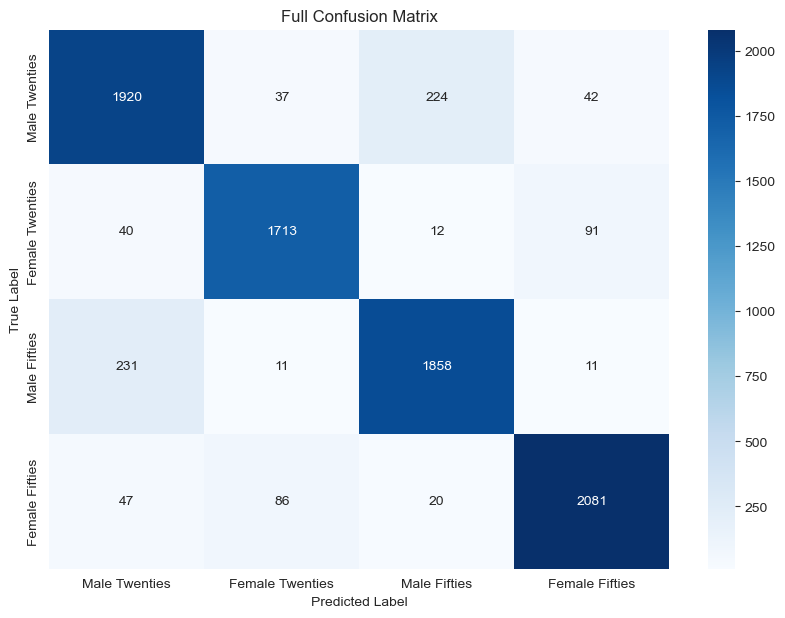

In [141]:

confusion_counts = classification_counts(y_test, stacking_pred)
all_labels = sorted(set(y_test) | set(stacking_pred))

df_3 = pd.DataFrame(0, index=all_labels, columns=all_labels)

for (true_label, pred_label), count in confusion_counts.items():
    df.loc[true_label, pred_label] = count

df_3.index = df_3.index.map(label_map)
df_3.columns = df_3.columns.map(label_map)

plt.figure(figsize=(10, 7))
sns.heatmap(df_3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Full Confusion Matrix')
plt.show()